In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 64
n_clusters=n_colors
# Load the Summer Palace photo
china = load_sample_image("china.jpg")

C:\Users\Magneto_Wang\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
C:\Users\Magneto_Wang\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


In [2]:
china = load_sample_image("china.jpg")

C:\Users\Magneto_Wang\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
C:\Users\Magneto_Wang\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


In [3]:
print(china.shape)

(427, 640, 3)


In [4]:
china = np.array(china, dtype=np.float64) / 255

In [5]:
print(china.shape)

(427, 640, 3)


In [6]:
w, h, d = original_shape = tuple(china.shape)

In [7]:
image_array = np.reshape(china, (w * h, d))

In [8]:
image_array_sample = shuffle(image_array, random_state=0)[:1000]

In [9]:
X=image_array_sample

In [22]:
image_array_sample

array([[ 0.92156863,  0.9254902 ,  0.94509804],
       [ 0.37647059,  0.37647059,  0.14117647],
       [ 0.48235294,  0.42745098,  0.41568627],
       ..., 
       [ 0.96862745,  0.96862745,  0.97647059],
       [ 0.9372549 ,  0.96470588,  1.        ],
       [ 0.11372549,  0.12156863,  0.07843137]])

In [14]:
import numpy as np
import scipy.sparse as sp

from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from sklearn.utils.extmath import row_norms, squared_norm, stable_cumsum
from sklearn.utils.sparsefuncs_fast import assign_rows_csr
from sklearn.utils.sparsefuncs import mean_variance_axis
from sklearn.utils import check_array
from sklearn.utils import check_random_state
from sklearn.utils import as_float_array
from sklearn.utils import gen_batches
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import FLOAT_DTYPES
from sklearn.externals.joblib import Parallel
from sklearn.externals.joblib import delayed
from sklearn.externals.six import string_types

In [19]:
X = as_float_array(X, "true")

In [21]:
X

array([[ 0.92156863,  0.9254902 ,  0.94509804],
       [ 0.37647059,  0.37647059,  0.14117647],
       [ 0.48235294,  0.42745098,  0.41568627],
       ..., 
       [ 0.96862745,  0.96862745,  0.97647059],
       [ 0.9372549 ,  0.96470588,  1.        ],
       [ 0.11372549,  0.12156863,  0.07843137]])

In [23]:
tol=1e-4

In [25]:
variances = np.var(X, axis=0)
np.mean(variances) * tol

1.1485336508522371e-05

In [26]:
tol=1.1485336508522371e-05

In [27]:
n_samples = X.shape[0]

In [29]:
precompute_distances = (n_colors * n_samples) < 12e6

In [30]:
X_mean = X.mean(axis=0)
X -= X_mean
x_squared_norms = row_norms(X, squared=True)
best_labels, best_inertia, best_centers = None, None, None

In [34]:
def _kmeans_single_elkan(X, n_clusters, max_iter=300, init='k-means++',
                         verbose=False, x_squared_norms=None,
                         random_state=None, tol=1e-4,
                         precompute_distances=True):
    if sp.issparse(X):
        raise ValueError("algorithm='elkan' not supported for sparse input X")
    X = check_array(X, order="C")
    random_state = check_random_state(random_state)
    if x_squared_norms is None:
        x_squared_norms = row_norms(X, squared=True)
    # init
    centers = _init_centroids(X, n_clusters, init, random_state=random_state,
                              x_squared_norms=x_squared_norms)
    centers = np.ascontiguousarray(centers)
    if verbose:
        print('Initialization complete')
    centers, labels, n_iter = k_means_elkan(X, n_clusters, centers, tol=tol,
                                            max_iter=max_iter, verbose=verbose)
    inertia = np.sum((X - centers[labels]) ** 2, dtype=np.float64)
    return labels, inertia, centers, n_iter


In [40]:
def _init_centroids(X, k, init, random_state=None, x_squared_norms=None,
                    init_size=None):

    random_state = check_random_state(random_state)
    n_samples = X.shape[0]

    if x_squared_norms is None:
        x_squared_norms = row_norms(X, squared=True)

    if init_size is not None and init_size < n_samples:
        if init_size < k:
            warnings.warn(
                "init_size=%d should be larger than k=%d. "
                "Setting it to 3*k" % (init_size, k),
                RuntimeWarning, stacklevel=2)
            init_size = 3 * k
        init_indices = random_state.randint(0, n_samples, init_size)
        X = X[init_indices]
        x_squared_norms = x_squared_norms[init_indices]
        n_samples = X.shape[0]
    elif n_samples < k:
        raise ValueError(
            "n_samples=%d should be larger than k=%d" % (n_samples, k))

    if isinstance(init, string_types) and init == 'k-means++':
        centers = _k_init(X, k, random_state=random_state,
                          x_squared_norms=x_squared_norms)
    elif isinstance(init, string_types) and init == 'random':
        seeds = random_state.permutation(n_samples)[:k]
        centers = X[seeds]
    elif hasattr(init, '__array__'):
        # ensure that the centers have the same dtype as X
        # this is a requirement of fused types of cython
        centers = np.array(init, dtype=X.dtype)
    elif callable(init):
        centers = init(X, k, random_state=random_state)
        centers = np.asarray(centers, dtype=X.dtype)
    else:
        raise ValueError("the init parameter for the k-means should "
                         "be 'k-means++' or 'random' or an ndarray, "
                         "'%s' (type '%s') was passed." % (init, type(init)))

    if sp.issparse(centers):
        centers = centers.toarray()

    _validate_center_shape(X, k, centers)
    return centers

In [43]:
def _k_init(X, n_clusters, x_squared_norms, random_state, n_local_trials=None):
    n_samples, n_features = X.shape

    centers = np.empty((n_clusters, n_features), dtype=X.dtype)

    assert x_squared_norms is not None, 'x_squared_norms None in _k_init'

    # Set the number of local seeding trials if none is given
    if n_local_trials is None:
        # This is what Arthur/Vassilvitskii tried, but did not report
        # specific results for other than mentioning in the conclusion
        # that it helped.
        n_local_trials = 2 + int(np.log(n_clusters))

    # Pick first center randomly
    center_id = random_state.randint(n_samples)
    if sp.issparse(X):
        centers[0] = X[center_id].toarray()
    else:
        centers[0] = X[center_id]

    # Initialize list of closest distances and calculate current potential
    closest_dist_sq = euclidean_distances(
        centers[0, np.newaxis], X, Y_norm_squared=x_squared_norms,
        squared=True)
    current_pot = closest_dist_sq.sum()

    # Pick the remaining n_clusters-1 points
    for c in range(1, n_clusters):
        # Choose center candidates by sampling with probability proportional
        # to the squared distance to the closest existing center
        rand_vals = random_state.random_sample(n_local_trials) * current_pot
        candidate_ids = np.searchsorted(stable_cumsum(closest_dist_sq),
                                        rand_vals)

        # Compute distances to center candidates
        distance_to_candidates = euclidean_distances(
            X[candidate_ids], X, Y_norm_squared=x_squared_norms, squared=True)

        # Decide which candidate is the best
        best_candidate = None
        best_pot = None
        best_dist_sq = None
        for trial in range(n_local_trials):
            # Compute potential when including center candidate
            new_dist_sq = np.minimum(closest_dist_sq,
                                     distance_to_candidates[trial])
            new_pot = new_dist_sq.sum()

            # Store result if it is the best local trial so far
            if (best_candidate is None) or (new_pot < best_pot):
                best_candidate = candidate_ids[trial]
                best_pot = new_pot
                best_dist_sq = new_dist_sq

        # Permanently add best center candidate found in local tries
        if sp.issparse(X):
            centers[c] = X[best_candidate].toarray()
        else:
            centers[c] = X[best_candidate]
        current_pot = best_pot
        closest_dist_sq = best_dist_sq

    return centers

In [45]:
def _validate_center_shape(X, n_centers, centers):
    """Check if centers is compatible with X and n_centers"""
    if len(centers) != n_centers:
        raise ValueError('The shape of the initial centers (%s) '
                         'does not match the number of clusters %i'
                         % (centers.shape, n_centers))
    if centers.shape[1] != X.shape[1]:
        raise ValueError(
            "The number of features of the initial centers %s "
            "does not match the number of features of the data %s."
            % (centers.shape[1], X.shape[1]))

In [54]:
def euclidean_distances(X, Y=None, Y_norm_squared=None, squared=False,
                        X_norm_squared=None):

    X, Y = check_pairwise_arrays(X, Y)

    if X_norm_squared is not None:
        XX = check_array(X_norm_squared)
        if XX.shape == (1, X.shape[0]):
            XX = XX.T
        elif XX.shape != (X.shape[0], 1):
            raise ValueError(
                "Incompatible dimensions for X and X_norm_squared")
    else:
        XX = row_norms(X, squared=True)[:, np.newaxis]

    if X is Y:  # shortcut in the common case euclidean_distances(X, X)
        YY = XX.T
    elif Y_norm_squared is not None:
        YY = np.atleast_2d(Y_norm_squared)

        if YY.shape != (1, Y.shape[0]):
            raise ValueError(
                "Incompatible dimensions for Y and Y_norm_squared")
    else:
        YY = row_norms(Y, squared=True)[np.newaxis, :]

    distances = safe_sparse_dot(X, Y.T, dense_output=True)
    distances *= -2
    distances += XX
    distances += YY
    np.maximum(distances, 0, out=distances)

    if X is Y:
        # Ensure that distances between vectors and themselves are set to 0.0.
        # This may not be the case due to floating point rounding errors.
        distances.flat[::distances.shape[0] + 1] = 0.0

    return distances if squared else np.sqrt(distances, out=distances)


In [55]:
def ones(shape, dtype=None, order='C'):

    a = empty(shape, dtype, order)
    multiarray.copyto(a, 1, casting='unsafe')
    return a

In [56]:
def partition(a, kth, axis=-1, kind='introselect', order=None):
    if axis is None:
        a = asanyarray(a).flatten()
        axis = 0
    else:
        a = asanyarray(a).copy(order="K")
    a.partition(kth, axis=axis, kind=kind, order=order)
    return a

In [58]:
def sum(a, axis=None, dtype=None, out=None, keepdims=np._NoValue):
    
    kwargs = {}
    if keepdims is not np._NoValue:
        kwargs['keepdims'] = keepdims
    if isinstance(a, _gentype):
        res = _sum_(a)
        if out is not None:
            out[...] = res
            return out
        return res
    if type(a) is not mu.ndarray:
        try:
            sum = a.sum
        except AttributeError:
            pass
        else:
            return sum(axis=axis, dtype=dtype, out=out, **kwargs)
    return _methods._sum(a, axis=axis, dtype=dtype,
                         out=out, **kwargs)


In [63]:
from sklearn.cluster import _k_means
from _k_means_elkan import k_means_elkan

AttributeError: type object 'sklearn.cluster._k_means_elkan.array' has no attribute '__reduce_cython__'

In [41]:
kmeans_single = _kmeans_single_elkan

In [52]:
for it in range(10):
    labels, inertia, centers, n_iter_ = kmeans_single(
        X, n_colors,max_iter=300, init='k-means++',
                         verbose=False, x_squared_norms=None,
                         random_state=None, tol=1e-4,
                         precompute_distances=True)
            # determine if these results are the best so far
    if best_inertia is None or inertia < best_inertia:
        best_labels = labels.copy()
        best_centers = centers.copy()
        best_inertia = inertia
        best_n_iter = n_iter_

NameError: name 'k_means_elkan' is not defined

C:\Users\Magneto_Wang\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
C:\Users\Magneto_Wang\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


Fitting model on a small sub-sample of the data
done in 0.101s.
Predicting color indices on the full image (k-means)
done in 0.084s.
Predicting color indices on the full image (random)
done in 0.085s.


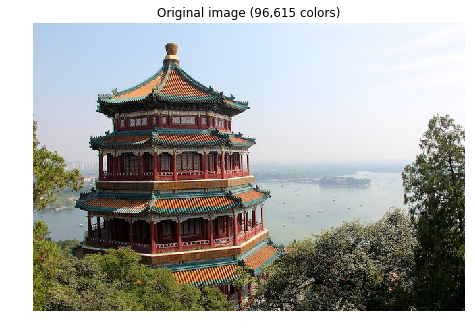

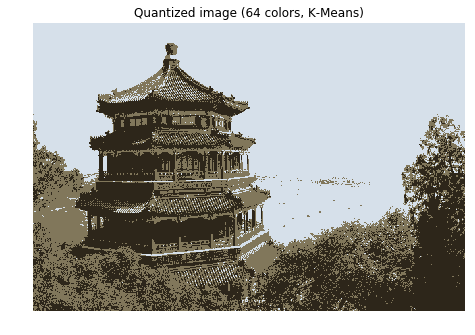

In [64]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun  1 00:02:06 2018

@author: Magneto_Wang
"""

#print(__doc__)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 3

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))


codebook_random = shuffle(image_array, random_state=0)[:n_colors + 1]
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)
print("done in %0.3fs." % (time() - t0))


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(china)

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))



In [66]:
labels.shape

(273280,)

In [68]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [69]:
def row_norms(X, squared=False):
    """Row-wise (squared) Euclidean norm of X.

    Equivalent to np.sqrt((X * X).sum(axis=1)), but also supports sparse
    matrices and does not create an X.shape-sized temporary.

    Performs no input validation.
    """
    if issparse(X):
        if not isinstance(X, csr_matrix):
            X = csr_matrix(X)
        norms = csr_row_norms(X)
    else:
        norms = np.einsum('ij,ij->i', X, X)

    if not squared:
        np.sqrt(norms, norms)
    return norms

In [70]:
image_array.shape

(273280, 3)

In [75]:
kmeans.cluster_centers_

array([[ 0.84182147,  0.88148435,  0.92131063],
       [ 0.17717087,  0.15148969,  0.10430354],
       [ 0.50842473,  0.46741442,  0.35893985]])

array([0, 0, 0, ..., 1, 1, 1])